# Lab 9 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Modelos Generativos

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Análise de sarcamos e sentimento com Modelos Sequenciais.

Data da entrega : 21/10 

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab7b.pdf"
- Envie o PDF via google [FORM](https://forms.gle/9VCKDGu5cqoNcYVK8)

Este notebook é baseado em tensorflow e Keras.

# Parte I - Análise de sarcamo com um base de dados em inglês (kaggle) (40pt)




**ToDO**: Veja o exemplo apresentado durante a aula, sobre detecção de [sarcasmo em textos inglês](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection). Execute o notebook do [link](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb). Modifique o modelo para um modelo sequencial (redes recorrentes ou um Transformer) e re-faça os testes. Com qual arquitetura você conseguiu melhorar os resultados? Tente explicar o por que.




Ao adicionar uma camada de Recorrencia (LSTM bidirecional) no lugar a convlayer1D, houve uma melhora nos resultados se comparado com o modelo original. A acurácia subiu da validação de 81% para .

A capacidade de memorização dests camada de alguma forme pôde auxiliar no desempenho da rede.

# Parte II - Análise de sentimento de um base em português (60pt)


A seguir, faremos um teste semelhante com dados em português. Os dados abaixo foram retirados do Twitter, em 2017. As contas monitoradas estavam comentando sobre o governo de Minas Gerais, e foi levantado o sentimento com relação ao governo.

## Carregando os pacotes

In [1]:
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn import metrics
from sklearn.model_selection import train_test_split
from string import punctuation
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Carregando a base (arquivo CSV - Tweets_minas_2017.dat)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
URL = '/content/drive/MyDrive/Datasets/Tweets_minas_2017/Tweets_minas_2017.dat'
dataframe = pd.read_csv(URL, encoding='utf-8')
dataframe.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
dataframe.columns

Index(['Unnamed: 0', 'Created At', 'Text', 'Geo Coordinates.latitude',
       'Geo Coordinates.longitude', 'User Location', 'Username',
       'User Screen Name', 'Retweet Count', 'Classificacao', 'Observação',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24'],
      dtype='object')

## Pré-processamento dos dados

In [8]:
# configura/renomeia o dataframe para campos que façam mais sentido
np.random.seed(42)
raw_df = (dataframe.rename(columns={"Created At": "publication_date",
                                "Text": "tweet",                                
                                "Retweet Count" : "num_retweets",
                                "Username": "username",
                                "Classificacao": "sentiment"})
               .loc[:, ["publication_date", "tweet", "num_retweets",  "username", "sentiment"]])
raw_df["publication_date"] = pd.to_datetime(raw_df["publication_date"],infer_datetime_format=True)
raw_df["sentiment"] = raw_df["sentiment"].replace({"Negativo": 0, "Neutro": np.random.choice([0, 1]), "Positivo": 1})

raw_df.head()

,publication_date,tweet,num_retweets,username,sentiment
0,2017-01-08 01:22:05+00:00,���⛪ @ Catedral de Santo Antônio - Governador ...,0,Leonardo C Schneider,0
1,2017-01-08 01:49:01+00:00,"� @ Governador Valadares, Minas Gerais https:/...",0,Wândell,0
2,2017-01-08 01:01:46+00:00,"�� @ Governador Valadares, Minas Gerais https:...",0,Wândell,0
3,2017-01-04 21:43:51+00:00,��� https://t.co/BnDsO34qK0,0,Ana estudando,0
4,2017-01-09 15:08:21+00:00,��� PSOL vai questionar aumento de vereadores ...,0,Emily,0


In [14]:
# veja a quantidade de exemplos positivos e negativos
neg, pos = np.bincount(raw_df['sentiment'])
total = neg + pos
print('Exemplos:\n    Total: {} \n    Negativos: {} ({:.2f}% do total)\n    Positivos: {} ({:.2f}% do total)\n'.format(
    total, neg, 100*neg/total, pos, 100 * pos / total))

Exemplos:
    Total: 8199 
    Negativos: 4899 (59.75% do total)
    Positivos: 3300 (40.25% do total)



Pode-se limpar o texto, excluindo-se caracteres estranhos ou infrequentes. Por exemplo, veja a função clean_text.


In [15]:
# limpa o texto
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## coloca tudo em caixa baixa
    text = text.lower().split()
    
    text = " ".join(text)
    ## limpa/altera 
    text = re.sub(r"pra", "para", text)
    text = re.sub(r"eh", "e", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"http://", "", text)
    text = re.sub(r"https://", "", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    ## 
    text = text.split()
    
    return text

Padronizar o texto ajuda o modelo de aprendizagem de máquina. Aplique a função de limpeza nos dados.

In [16]:
# Aplica a função acima e limpa o texto
raw_df['tweet'] = raw_df['tweet'].map(lambda x: clean_text(x))

In [17]:
#  a data da publicação não parece interessante para o nosso contexto. Vamos descarta-la, junto com mais algumas colunas (retweets, username).
cleaned_df = raw_df.copy()

# descara data da publicação, numero de retweets e username
cleaned_df.pop('publication_date')
cleaned_df.pop('num_retweets')
cleaned_df.pop('username')

cleaned_df.head()

,tweet,sentiment
0,"[���⛪, @, catedral, de, santo, antônio, -, gov...",0
1,"[�, @, governador, valadares, minas, gerais, h...",0
2,"[��, @, governador, valadares, minas, gerais, ...",0
3,"[���, https, :, t, co, bndso34qk0]",0
4,"[���, psol, vai, questionar, aumento, de, vere...",0


In [31]:
dataframe = cleaned_df.copy()
labels = dataframe.pop('sentiment')
data = dataframe.pop('tweet')

Use o objeto Tokenizer para separar o texto em vários tokens. Uma instância de dados deve ter um tamanho máximo para modelos de redes neurais. Consideraremos, aqui, que um tweet terá 30 tokens, no máximo. Tweets menores serão completados com zero (zero padding, pad_sequences). Veja que o objeto Tokenizer também oferece uma forma de se filtrar caracteres não desejados.

In [32]:
tk = Tokenizer(lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tk.fit_on_texts(data)
word_index = tk.word_index
print(len(word_index))
print(word_index)

max_len = 30 # tamanho maximo para um twitte
train_tokenized = tk.texts_to_sequences(data)
X = np.array(pad_sequences(train_tokenized, maxlen=max_len))

y = np.array(labels)

print(X[0])

13807
{':': 1, 'de': 2, 'https': 3, 't': 4, 'co': 5, 'em': 6, 'minas': 7, 'rt': 8, '-': 9, 'estado': 10, 'mg': 11, 'e': 12, 'a': 13, 'governo': 14, 'o': 15, '+': 16, 'do': 17, 'helicópteros': 18, 'é': 19, 'que': 20, 'gerais': 21, 'mais': 22, 'calamidade': 23, '!': 24, 'dois': 25, 'drogas': 26, 'com': 27, 'financeira': 28, 'compara': 29, 'para': 30, 'não': 31, 'são': 32, 'governador': 33, 'q': 34, 'da': 35, 'pimentel': 36, 'no': 37, 'presídio': 38, 'por': 39, 'febre': 40, 'na': 41, 'amarela': 42, 'tem': 43, 'r$': 44, '2': 45, 'roubo': 46, 'ainda': 47, 'mesmo': 48, 'tráfico': 49, 'dos': 50, 'contra': 51, 'presos': 52, 'preso': 53, 'polícia': 54, 'só': 55, 'via': 56, 'cara': 57, 'três': 58, 'pau': 59, 'anos': 60, '@pmmg190': 61, 'justiça': 62, 'recursos': 63, 'conta': 64, 'ñ': 65, 'htt…': 66, 'canalhice': 67, 'maiores': 68, 'avisa': 69, '8': 70, 'bb': 71, '@anapaulavolei': 72, 'vive': 73, 'após': 74, 'pm': 75, 'valadares': 76, 'fernando': 77, 'milhões': 78, 'juiz': 79, 'privado': 80, 'tev

In [34]:
print(X.shape)

(8199, 30)


Observe que cada token recebe um valor único. O comando abaixo imprime a instância X[100].



In [35]:
print(X[100])

[   0    0    0    0    0    0    0    0    0 4809 1645  270 4810   35
 4811   41 2131 4812   35 2557 4813  253 4814    1   99    3    1    4
    5 4815]


In [36]:
# divide em 80% treino e 20% validação.
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2)
print(len(train_X), 'exemplos de treino')
print(len(val_X), 'exemplos de validação')
print(len(test_X), 'exemplos de test')

5247 exemplos de treino
1312 exemplos de validação
1640 exemplos de test


##ToDo:  Construa uma rede recorrente para fazer uma análise de sentimentos. (40pt)

In [44]:
# Se necessário, mude o shape de train_X e val_X

# Monta o modelo sequencial
embed_dim = 60 # fique a vontade para escolher a quantidade de dimensões da camada de embeddings
max_fatures = X.max() + 1 # número máximo de palavras da base de treino + uma

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_fatures, embed_dim, input_length=max_len),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(units = 16, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units = 1, activation='sigmoid')
])

 


# compila  
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# imprime o modelo
print(model.summary())


# treina

n_epochs = 20 # escolha o numero de epocas

model.fit(train_X, train_y, epochs=n_epochs, validation_data=(val_X,val_y))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 60)            828480    
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              64000     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 894,561
Trainable params: 894,561
Non-trainable params: 0
________________________________________________

## ToDo: Avaliação do modelo (10pt)

**ToDo:** Faça uma avaliação dos resultados encontrados. Você pode usar métricas como precisão, revocação, F1-score, acurácia, etc.

```
    Valores próximos de 0 => sentimento Negativo
    Valores próximos de 1 => sentimento Positivo
```

,Acurácia,Revogação,Precisão,F1-Score
Positive,0.981098,0.971299,0.981679,0.976462
Negative,0.981098,0.981679,0.971299,0.976462


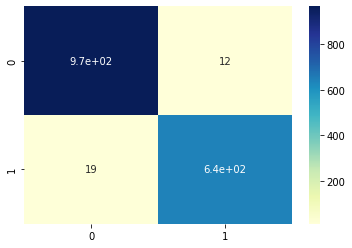

In [126]:
import seaborn as sns
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd 

pred_y = (model.predict(test_X).ravel() > .5).astype(int)

accuracy = lambda x,y: Accuracy()(x,y).numpy()
precision = lambda x,y: Precision()(x,y).numpy()
recall = lambda x,y: Recall()(x,y).numpy()
f1_score = lambda x,y: (2*precision(x,y)*recall(x,y))/(precision(x,y)+recall(x,y))


tf.math.confusion_matrix( test_y, pred_y ) 
sns.heatmap(tf.math.confusion_matrix( test_y, pred_y ), annot=True, cmap="YlGnBu")

metrics = { 
      "Positive": [ accuracy(test_y, pred_y), recall(test_y, pred_y), precision(test_y, pred_y), f1_score(test_y, pred_y) ],
      "Negative": [ accuracy(pred_y, test_y), recall(pred_y, test_y), precision(pred_y, test_y), f1_score(pred_y, test_y) ]
      }
pd.DataFrame.from_dict(metrics, orient='index', columns=["Acurácia", "Revogação", "Precisão", "F1-Score"])


**ToDo:** Quais conclusões você chegou?

Considerando os dados de teste, eu acho que o modelo obteve um bom desempenho, com cerca de 98% de acerto. 

A precisão para cada uma das classes ficaram bem semelhantes também. Acho que não houve uma variância significativa para dizer se o modelo erra mais por FP ou FN.

## ToDo: Testando as frases (10pt)

In [127]:
# função para avaliar um tweet
def sample_predict(sentence):
  max_len = 30 # numero maximo de palavras em um tweet
  tk_sentence = tk.texts_to_sequences(sentence)
  print(tk_sentence)
  encoded_sample_pred_text = np.array(pad_sequences(tk_sentence, maxlen=max_len))
  predictions = model.predict(encoded_sample_pred_text)
  return (predictions)

Teste as frases abaixo e verifique se o seu modelo é coerente.

In [159]:
sample_pred_text = {'pimentel governa bem, faz um bom trabalho.'}
predictions = sample_predict(sample_pred_text)
print("{:.20f}".format(predictions[0][0]))

[[36, 3439, 1001, 226, 90, 261, 426]]
0.99989712238311767578


In [158]:
sample_pred_text = {'O governo de minas esta ruim. o governador anda roubando, o povo quer coisas melhores. fora governo.'}
predictions = sample_predict(sample_pred_text)
print("{:.20f}".format(predictions[0][0]))

[[15, 14, 2, 7, 326, 1285, 15, 33, 2920, 15, 407, 179, 5451, 84, 14]]
0.00000007341417074258


In [172]:
sample_pred_text = {'governo fez melhorias na saúde e educação. É um ótimo governo. adoro pimentel.'}
predictions = sample_predict(sample_pred_text)
print("{:.20f}".format(predictions[0][0]))

[[14, 1113, 41, 198, 12, 142, 19, 90, 3004, 14, 8443, 36]]
1.00000000000000000000


In [167]:
sample_pred_text = {'governo de m**da, só sabe roubar!!'}
predictions = sample_predict(sample_pred_text)
print("{:.20f}".format(predictions[0][0]))

[[14, 2, 106, 35, 55, 1676, 4130]]
0.00000290389016299741


**ToDo:** O que você pode dizer sobre as predições?

Que as predições de teste foram boas. Nos textos acima percebe-se que algumas palavras-chaves que geralmente estão associadas a um texto negativo ou positivo. Estas palavras podem ajudar estar favorecendo na classificação do modelo.

Talvez em alguns casos que não esteja tão evidente a intenção/sentimento contido no tweet, o modelo possa ter alguma dificuldde.